# A quick example of standard detection pipeline

 
# Gravitational Wave Matched Filter

The Gravitational Wave (GW) matched filter is a crucial tool in the detection of gravitational waves.  The matched filter operates by correlating the incoming data stream from the gravitational wave detector with a theoretically predicted waveform template. This template is derived from the expected signal characteristics based on gravitational wave theory and the properties of potential astrophysical sources.

## Implementation

1. **Template Generation**: Construct theoretical waveform templates corresponding to different gravitational wave sources using numerical relativity simulations or analytical approximations.

2. **Cross-correlation**: Slide the generated templates over the detector data stream and compute the cross-correlation between the templates and the data at each point in time.

3. **Signal Identification**: Look for significant peaks in the correlation output that exceed a predefined threshold. These peaks indicate the presence of a potential gravitational wave signal.

4. **Parameter Estimation**: Once a candidate event is identified, refine the estimation of its parameters (such as source location, masses, and orbits) using additional statistical techniques.

## Advantages

- **Optimal SNR Enhancement**: The matched filter provides the optimal signal enhancement by maximizing the correlation between the expected signal and the detector output.
  
- **Statistical Significance**: By setting appropriate threshold levels, the matched filter helps in distinguishing true gravitational wave events from random fluctuations in the detector noise.

- **Robustness**: It can handle various sources of noise and signal distortions, making it a robust technique for gravitational wave detection.

 

The objective of this exercise is to gain a practical understanding of the Gravitational Wave (GW) matched filter technique and its application in the detection of gravitational wave signals.
We will use materials from the GWOSC workshop:
    https://github.com/gw-odw/odw-2022/tree/main

**Introduction to PyCBC**

PyCBC is an open-source software package developed for gravitational wave data analysis and astrophysics research. It provides a comprehensive suite of tools and algorithms designed to analyze data from gravitational wave detectors such as LIGO and Virgo.

With PyCBC, researchers can process, analyze, and interpret gravitational wave signals, enabling them to extract valuable information about astrophysical phenomena such as black hole mergers, neutron star collisions, and other cataclysmic events in the universe.

Key features of PyCBC include:
- Signal processing: PyCBC offers advanced signal processing techniques for noise reduction, event detection, and parameter estimation.
- Parameter estimation: It provides tools for estimating the parameters of gravitational wave sources, such as their masses, spins, and distances.
- Simulation: PyCBC allows researchers to simulate gravitational wave signals and test the performance of different analysis methods.
- Visualization: The package includes visualization tools for exploring and interpreting gravitational wave data.

PyCBC is actively maintained and developed by a community of researchers and developers, making it a valuable resource for both beginners and experts in the field of gravitational wave astronomy.

More info here: https://pycbc.org/
 

In [1]:
# Import sys module
import sys

# Update sys.path to include the specified directory
sys.path = ['/cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages'] + sys.path

# Import gwpy module
import gwpy

# Import TimeSeries class from gwpy.timeseries module
from gwpy.timeseries import TimeSeries

# Import pyplot module from matplotlib library
from matplotlib import pyplot as plt

# Import numpy library
import numpy

# Import pylab module from matplotlib library
import pylab

# Import pandas library
import pandas as pd

# Import seaborn library
import seaborn as sns

# Set matplotlib configuration parameters for figure size and grid
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['axes.grid'] = False



/cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/gwpy/time/__init__.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(True)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS
/cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/cvmfs/software.igw

In [2]:
MDC_PATH = "/cvmfs/et-gw.osgstorage.org/et-gw/PUBLIC/MDC1/data"
DATASETS = ['E0','E1','E2','E3','C1','C2']
CHANNELS = {n : f'{n}:STRAIN' for n in DATASETS}

In [3]:
signals = pd.read_csv('../metadata/list_etmdc1_snr.txt', sep=' ')

There are 6767 signals with SNR>15.


/cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


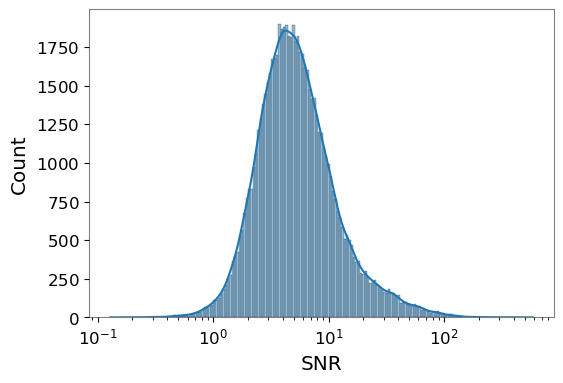

In [4]:
# Plot distribution of SNRs
print(f'There are {sum(signals["SNR"]>15)} signals with SNR>15.')
fig = plt.figure(figsize=(6,4))
ax = fig.gca()
sns.histplot(signals['SNR'], log_scale=(True,False), kde=True, ax=ax)
plt.show()


## Let's produce some template waveform to match our injected signal 

### IMRPhenomD

`IMRPhenomD` is a gravitational waveform model used in the analysis of gravitational wave signals produced by the inspiral, merger, and ringdown of compact binary systems, such as binary black holes or binary neutron stars. This model is an extension of the `IMRPhenom` family of waveform models developed for the LIGO/Virgo Collaboration.

The "IMR" stands for "Inspiral-Merger-Ringdown," which are the three phases of the gravitational wave signal emitted during the coalescence of compact binaries. The "Phenom" part refers to "Phenomenological," indicating that the model is constructed based on a combination of theoretical insights and empirical fits to numerical simulations rather than being derived from first principles.

`IMRPhenomD` incorporates improvements over earlier versions, such as `IMRPhenomC` and `IMRPhenomPv2`, by including more accurate waveform descriptions, particularly in the high-frequency regime where post-Newtonian approximations are less reliable.

### IMRPhenomXPHM
`IMRPhenomXPHM` is a gravitational waveform model used in the analysis of gravitational wave signals originating from the inspiral, merger, and ringdown phases of compact binary systems, such as binary black holes or binary neutron stars. It belongs to the family of `IMRPhenom` waveform models 
 
It incorporates advancements in understanding and modeling of gravitational waveforms, particularly focusing on high-frequency features and the treatment of various physical effects such as precession, higher-order post-Newtonian corrections, and tidal effects in the case of neutron star binaries.

 
While both `IMRPhenomD` and `IMRPhenomXPHM` are phenomenological waveform models used in gravitational wave astronomy, they may differ in their construction, accuracy, coverage of parameter space, and specific modeling assumptions.  

In [5]:
from pycbc.waveform import get_td_waveform

# the "approximant" (jargon for parameterized waveform family).
# IMRPhenomD(a phenomenological Inspiral–Merger–Ringdown wafeform model) is defined in the frequency domain, but we'll get it in the time domain (td).
# It runs fast, but it doesn't include effects such as non-aligned component spin, or higher order modes.
apx1 ='IMRPhenomD'
apx2= 'IMRPhenomXPHM'
 
 

let's prepare some template to play with

In [6]:
# Define the sample rate
sample_rate = 8192

# Generate the gravitational waveform (hp1) using the specified parameters and waveform model (approximant)
# Parameters: mass1, mass2, delta_t (time step), f_lower (lower frequency cutoff)
hp1, _ = get_td_waveform(approximant=apx1,
                         mass1=30,
                         mass2=30,
                         delta_t=1.0/sample_rate,
                         f_lower=10)

# Generate the gravitational waveform (hp2) using the specified parameters and waveform model (approximant)
# Parameters: mass1, mass2, delta_t (time step), f_lower (lower frequency cutoff)
hp2, _ = get_td_waveform(approximant=apx2,
                         mass1=30,
                         mass2=30,
                         delta_t=1.0/sample_rate,
                         f_lower=10)


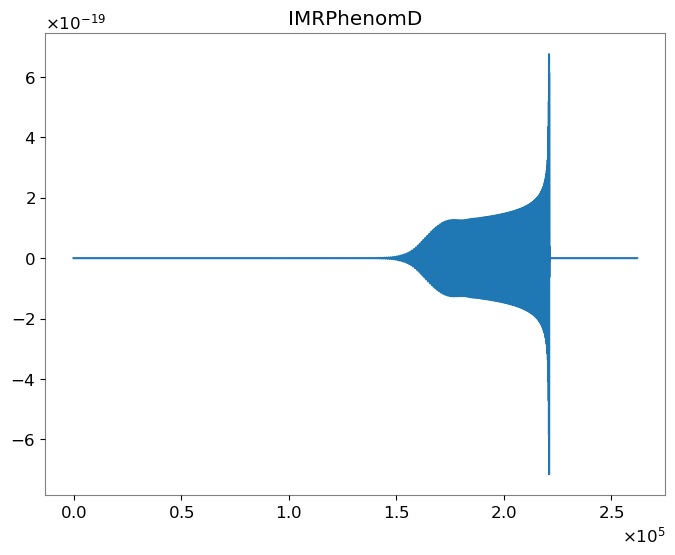

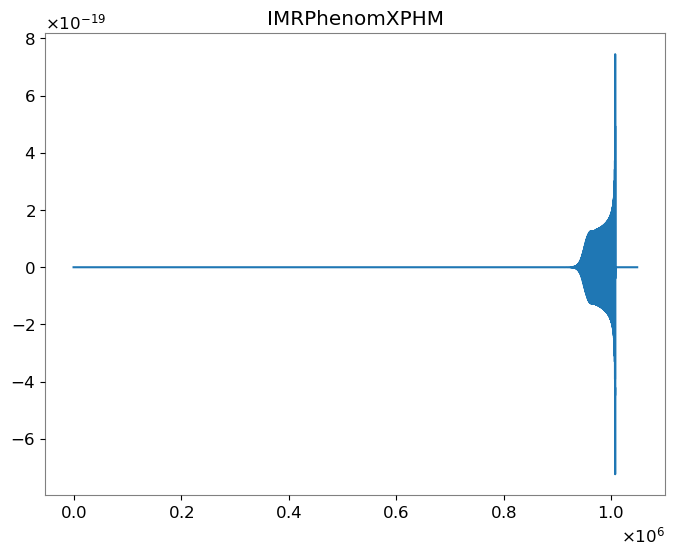

In [7]:
plt.figure()
plt.title('IMRPhenomD')
plt.plot(hp1)
 
plt.figure()
plt.title('IMRPhenomXPHM')
plt.plot(hp2)
 

 

Inj 42581, tc 1001620463.11925, Masses: (24.386689, 23.987984), chirp length 8.715954576399563 s, SNR 587.553918


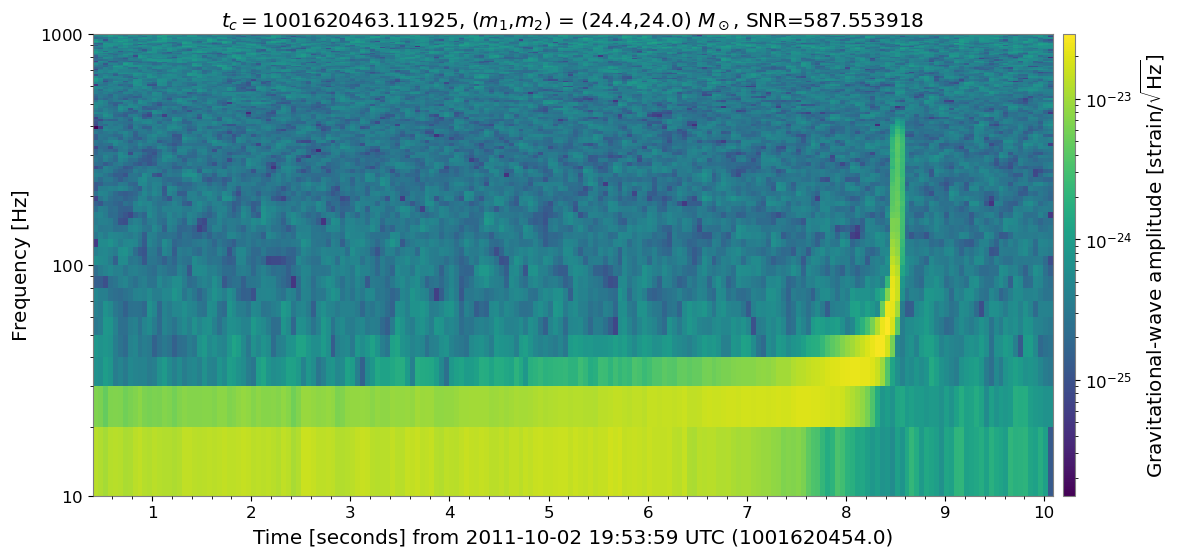

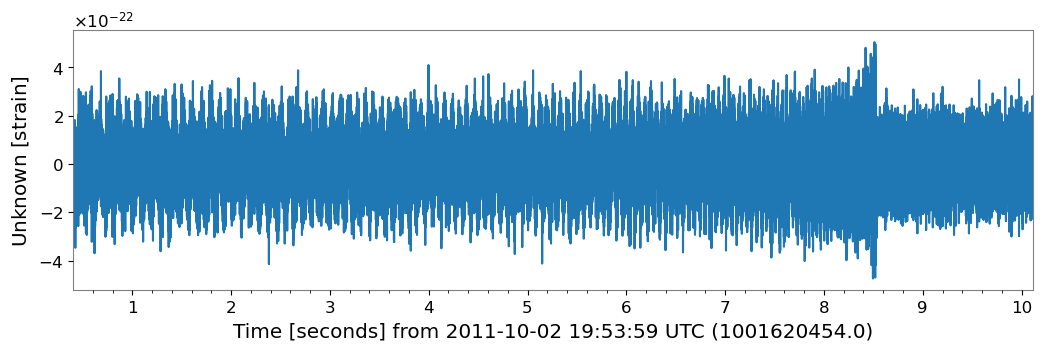

In [8]:
import lal
from lal import MSUN_SI as Msun
from lalsimulation import SimIMRPhenomDChirpTime
# Choose the top few signals to plot
Nplot = 1
top_sigs = signals.iloc[:Nplot]

def read_without_warnings(cachefile, channel, **kwargs):
    """Reads cache file while suppressing spurious LAL warnings.
    Wraps gwpy.timeseries.TimeSeries.read

    Args:
        cachefile (str): path to cache file
        channel (str): Channel name
        **kwargs: additional arguments passed to TimeSeries.read
    """
    prev_level = lal.GetDebugLevel()
    lal.ClobberDebugLevel(0)
    result = TimeSeries.read(cachefile, channel, **kwargs)
    lal.ClobberDebugLevel(prev_level)
    return result

def get_strain(tc, t_before = 4, t_after = 1):
    start_time = tc - t_before
    end_time = tc + t_after
    h = read_without_warnings('../caches/E1.lcf','E1:STRAIN',start=start_time, end=end_time)
    return h

def plot_specgram2(h):
    specgram = h.spectrogram2(fftlength=1/10,overlap=1/50)**(1/2)
    return specgram

for idx, pars in top_sigs.iterrows():
    tc =pars['tc']
    m1 = pars['m1']
    m2 = pars['m2']
    f_min = 10
    chirplen = SimIMRPhenomDChirpTime(pars['m1']*Msun, pars['m2']*Msun, pars['s1z'], pars['s2z'], f_min )
    print(f'Inj {int(pars["#"])}, tc {pars["tc"]}, Masses: {pars["m1"],pars["m2"]}, chirp length {chirplen} s, SNR {pars["SNR"]}')
    h = get_strain(tc, t_before=max(4,min(30,chirplen)))
    sg = h.spectrogram2(fftlength=1/10)**(1/2)
    plot = sg.plot(norm='log', yscale='log',
                   title=f'$t_c={tc}$, ($m_1$,$m_2$) = ({pars["m1"]:.1f},{pars["m2"]:.1f}) $M_\odot$, SNR={pars["SNR"]}',
                   ylim=(10,1000))
    ax = plot.gca()
    ax.colorbar(
        label=r'Gravitational-wave amplitude [strain/$\sqrt{\mathrm{Hz}}$]')
    h.plot()
plt.show()

In [9]:
# Define the GPS time of the event
tc = 1001620463.11925

# Obtain strain data 'h' centered around the event time 'tc'
# Parameters: tc (event time), t_before (time before event), t_after (time after event)
h = get_strain(tc, t_before=16, t_after=16)

262144


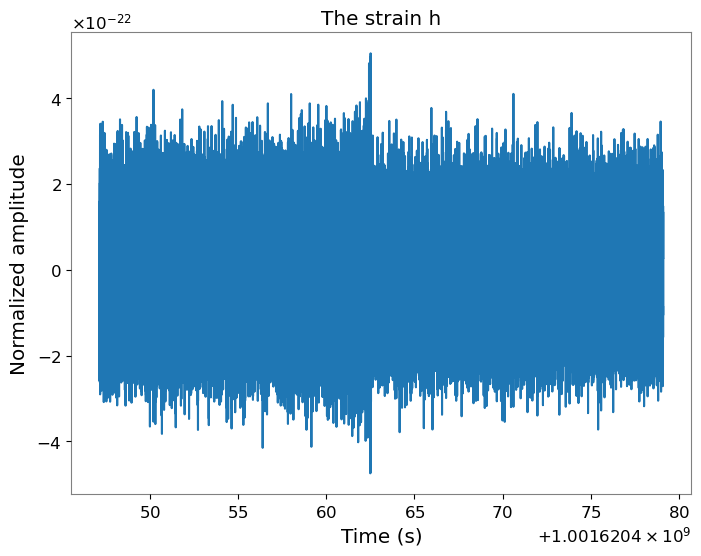

In [10]:
pylab.figure()
pylab.title("The strain h")
pylab.plot( h)
pylab.xlabel('Time (s)')
pylab.ylabel('Normalized amplitude')
print (len(h))

In [11]:
# Import necessary functions and modules from pycbc library
from pycbc.filter import resample_to_delta_t, highpass
from pycbc.types import TimeSeries

# Import numpy library
import numpy as np

# Define the sample rate
fs = 8192

# Calculate the time step
time_step = 1 / fs

# Define the start time
start_time = tc  - 16

# Create a TimeSeries object 'strain' from the provided data 'h' for pyCBC format
strain = TimeSeries(np.array(h), delta_t=time_step, epoch=start_time)


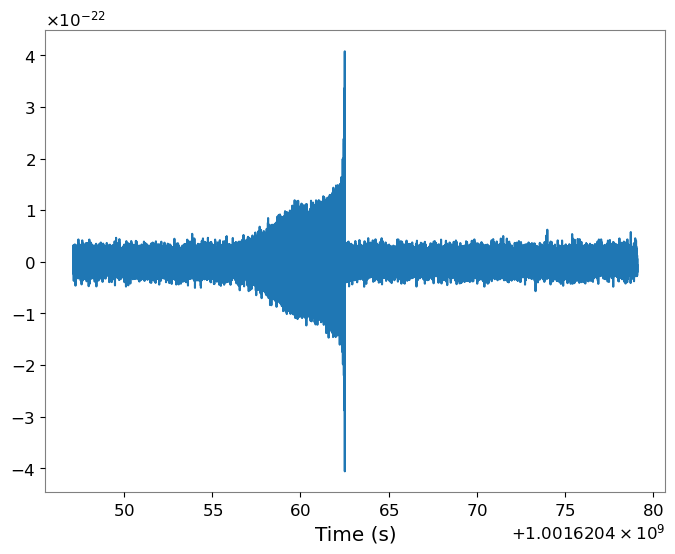

In [12]:
# Remove the low frequency content and downsample the data to 2048Hz
strain = highpass(strain, 15.0)
strain = resample_to_delta_t(strain, 1.0/2048)

pylab.plot(strain.sample_times, strain)
pylab.xlabel('Time (s)')
pylab.show()

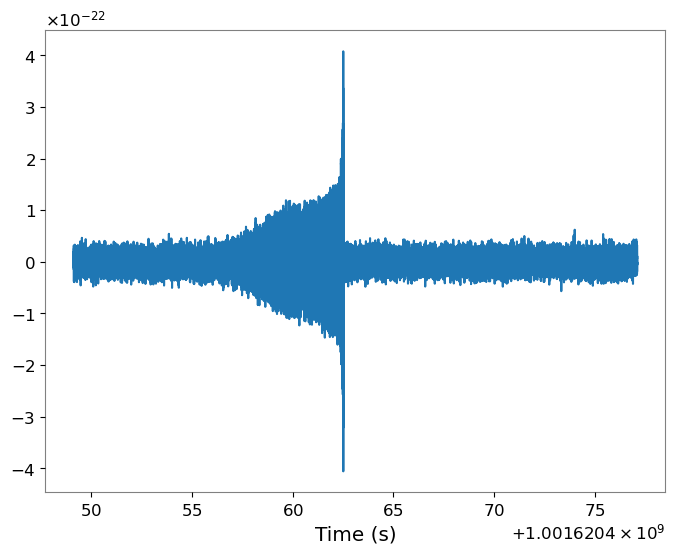

In [13]:
# Remove 2 seconds of data from both the beginning and end
conditioned = strain.crop(2, 2)

pylab.plot(conditioned.sample_times, conditioned)
pylab.xlabel('Time (s)')
pylab.show()

In [14]:
from pycbc.psd import interpolate, inverse_spectrum_truncation
# Estimate the power spectral density

# We use 4 second samples of our time series in Welch method.
psd = conditioned.psd(4)

# Now that we have the psd we need to interpolate it to match our data
# and then limit the filter length of 1 / PSD. After this, we can
# directly use this PSD to filter the data in a controlled manner
psd = interpolate(psd, conditioned.delta_f)

# 1/PSD will now act as a filter with an effective length of 4 seconds
# Since the data has been highpassed above 15 Hz, and will have low values
# below this we need to inform the function to not include frequencies
# below this frequency. 
psd = inverse_spectrum_truncation(psd, int(4 * conditioned.sample_rate),
                                  low_frequency_cutoff=15)

In [15]:
from pycbc.waveform import get_td_waveform

m = 20 # Solar masses
hp, hc = get_td_waveform(approximant='IMRPhenomD',
                     mass1=m,
                     mass2=m,
                     delta_t=conditioned.delta_t,
                     f_lower=20)

# Resize the vector to match our data
hp.resize(len(conditioned))

Text(0, 0.5, 'Strain')

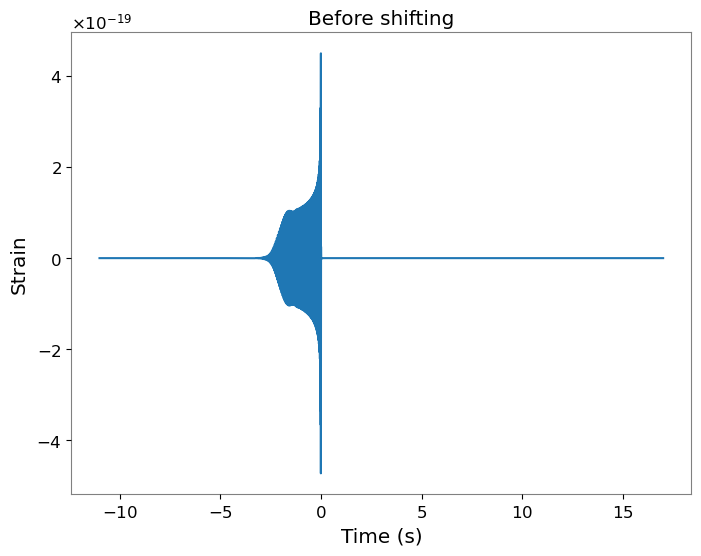

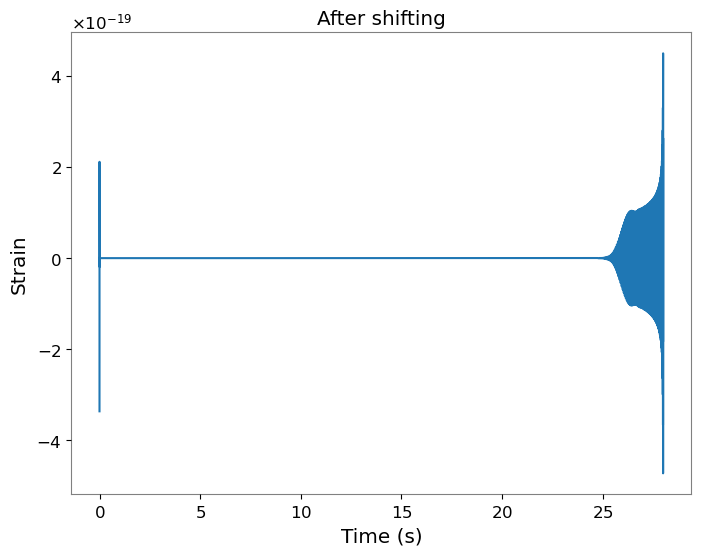

In [16]:
# Let's plot the signal before and after shifting

pylab.figure()
pylab.title('Before shifting')
pylab.plot(hp.sample_times, hp)
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')

template = hp.cyclic_time_shift(hp.start_time)

pylab.figure()
pylab.title('After shifting')
pylab.plot(template.sample_times, template)
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')

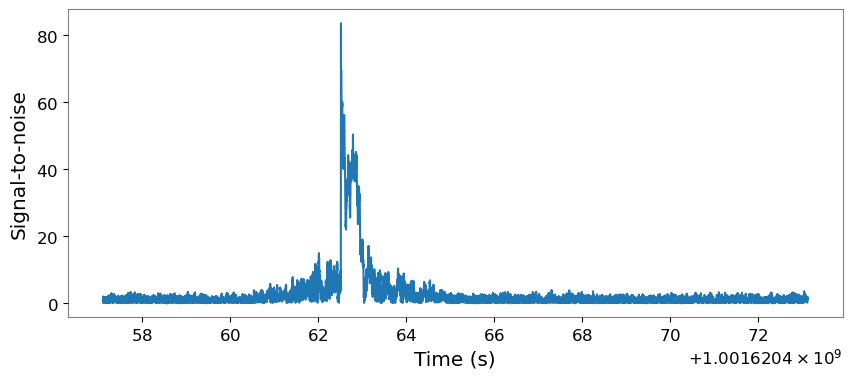

We found a signal at 1001620462.5235469s with SNR 83.60037622702487


In [17]:
from pycbc.filter import matched_filter
import numpy

snr = matched_filter(template, conditioned,
                     psd=psd, low_frequency_cutoff=20)

# Remove time corrupted by the template filter and the psd filter
# We remove 4 seconds at the beginning and end for the PSD filtering
# And we remove 4 additional seconds at the beginning to account for
# the template length (this is somewhat generous for 
# so short a template). A longer signal such as from a BNS, would 
# require much more padding at the beginning of the vector.
snr = snr.crop(4 + 4, 4)

# Why are we taking an abs() here?
# The `matched_filter` function actually returns a 'complex' SNR.
# What that means is that the real portion correponds to the SNR
# associated with directly filtering the template with the data.
# The imaginary portion corresponds to filtering with a template that
# is 90 degrees out of phase. Since the phase of a signal may be 
# anything, we choose to maximize over the phase of the signal.
pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, 
                                                    abs(snrp)))

In [18]:
m = 24 # Solar masses
hp, hc = get_td_waveform(approximant='IMRPhenomD',
                     mass1=m,
                     mass2=m,
                     delta_t=conditioned.delta_t,
                     f_lower=20)

# Resize the vector to match our data
hp.resize(len(conditioned))

Text(0, 0.5, 'Strain')

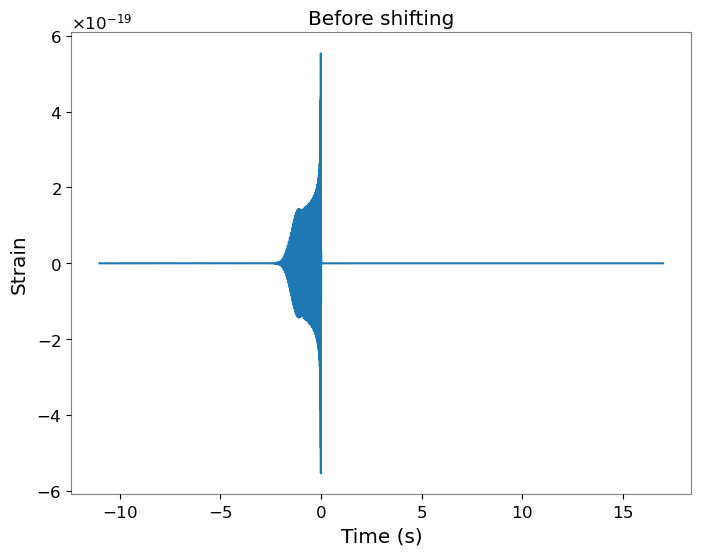

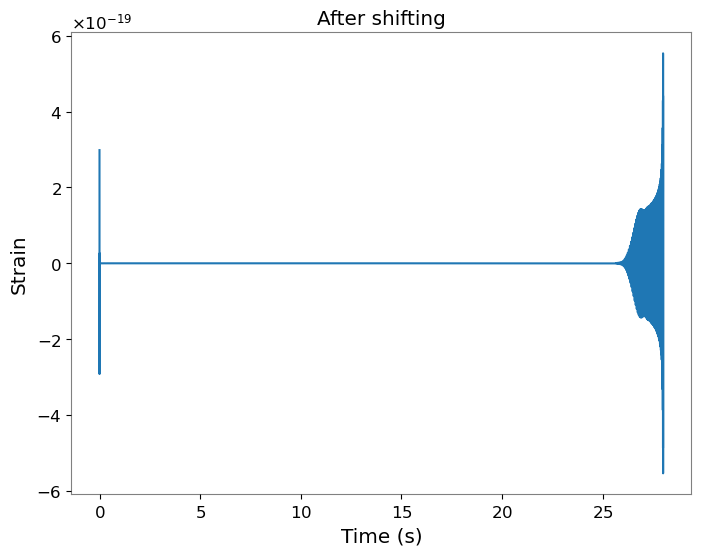

In [19]:
# Let's plot the signal before and after shifting

pylab.figure()
pylab.title('Before shifting')
pylab.plot(hp.sample_times, hp)
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')

template = hp.cyclic_time_shift(hp.start_time)

pylab.figure()
pylab.title('After shifting')
pylab.plot(template.sample_times, template)
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')

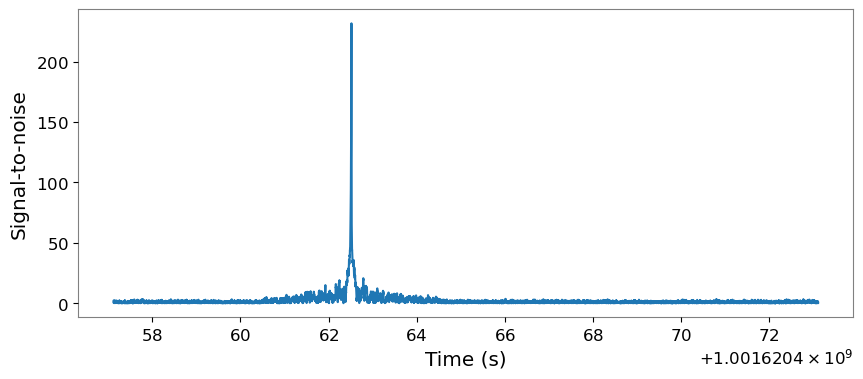

We found a signal at 1001620462.5206172s with SNR 231.67149879152382


In [20]:
snr = matched_filter(template, conditioned,
                     psd=psd, low_frequency_cutoff=20)

# Remove time corrupted by the template filter and the psd filter
# We remove 4 seconds at the beginning and end for the PSD filtering
# And we remove 4 additional seconds at the beginning to account for
# the template length (this is somewhat generous for 
# so short a template). A longer signal such as from a BNS, would 
# require much more padding at the beginning of the vector.
snr = snr.crop(4 + 4, 4)

# Why are we taking an abs() here?
# The `matched_filter` function actually returns a 'complex' SNR.
# What that means is that the real portion correponds to the SNR
# associated with directly filtering the template with the data.
# The imaginary portion corresponds to filtering with a template that
# is 90 degrees out of phase. Since the phase of a signal may be 
# anything, we choose to maximize over the phase of the signal.
pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, 
                                                    abs(snrp)))

## <span style="color:purple;">What happen with a low SNR signal?</span>